In [1]:
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.morphology import skeletonize
from scipy.spatial import KDTree
import os
from glob import glob
import cv2

def load_images_from_folder(folder):
    images = {}
    for pattern in ('*.bmp','*.BMP'):
        for path in glob(os.path.join(folder, pattern)):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images[os.path.basename(path)] = img
    return images

train_folder = './train'
test2_folder = './test2'
test1_folder = './test1'

train_images = load_images_from_folder(train_folder)
test2_images = load_images_from_folder(test2_folder)
test1_images = load_images_from_folder(test1_folder)

print(f"Loaded {len(train_images)} train, {len(test2_images)} test2, {len(test1_images)} test1")

Loaded 477 train, 1428 test2, 477 test1


In [2]:
def preprocess_with_mask(img):
    # 1) 노이즈 제거
    img_blur = cv2.medianBlur(img, 5)
    # 2) Otsu 이진화
    _, bin_otsu = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # 3) convex hull로 ROI mask
    mask = convex_hull_image(bin_otsu > 0).astype(np.uint8)
    mask = cv2.erode(mask, np.ones((3,3), np.uint8), iterations=1)
    # 4) adaptive threshold
    T = threshold_local(img_blur, block_size=35, method='gaussian', offset=10)
    bin_adapt = (img_blur < T).astype(np.uint8)
    # 5) mask 적용
    bin_masked = bin_adapt * mask
    # 6) 세선화
    skel = skeletonize(bin_masked).astype(np.uint8)
    return skel, mask

In [3]:
from scipy.ndimage import convolve

def extract_minutiae_original(img, block_size=35, offset=10):
    """
    원본 방식(minutiae_original) – 
    1) threshold_local로 이진화
    2) skeletonize
    3) 3x3 윈도우 루프 방식으로 minutiae 검출
    """
    T = threshold_local(img, block_size, method='gaussian', offset=offset)
    binary = (img < T)
    sk = skeletonize(binary).astype(np.uint8)
    rows, cols = sk.shape
    bif = []
    end = []
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if sk[i, j] == 1:
                window = sk[i-1:i+2, j-1:j+2]
                neighbor_count = np.sum(window) - 1  # 중앙 제외
                if neighbor_count == 1:
                    end.append((j, i))
                elif neighbor_count == 3:
                    bif.append((j, i))
    minutiae = {'bif': bif, 'end': end}
    return sk, minutiae

def extract_minutiae_fast(img, block_size=35, offset=10):
    """
    속도 개선 버전 numpy 컨볼루션으로 endpoint/bifurcation 검출
    """
    T = threshold_local(img, block_size, method='gaussian', offset=offset)
    binary = (img < T)
    sk = skeletonize(binary).astype(np.uint8)
    # 3x3 커널로 이웃 픽셀 수 계산
    kernel = np.ones((3,3), dtype=np.uint8)
    neighbor_count = convolve(sk, kernel, mode='constant', cval=0) - sk
    # endpoint: 이웃 1개, bifurcation: 이웃 3개
    end_mask = (sk == 1) & (neighbor_count == 1)
    bif_mask = (sk == 1) & (neighbor_count == 3)
    y_end, x_end = np.where(end_mask)
    y_bif, x_bif = np.where(bif_mask)
    end = list(zip(x_end, y_end))
    bif = list(zip(x_bif, y_bif))
    minutiae = {'bif': bif, 'end': end}
    return sk, minutiae


In [4]:
import time

sample_img = list(test1_images.values())[0]

start_o = time.time()
_ = extract_minutiae_original(sample_img)
end_o = time.time()
elapsed_o = end_o - start_o

start_f = time.time()
_ = extract_minutiae_fast(sample_img)
end_f = time.time()
elapsed_f = end_f - start_f

print(f"extract_minutiae_original: {elapsed_o:.6f} sec")
print(f"extract_minutiae_fast:     {elapsed_f:.6f} sec")
print(f"Speedup: {elapsed_o/elapsed_f:.2f}x")

extract_minutiae_original: 0.138497 sec
extract_minutiae_fast:     0.000000 sec


ZeroDivisionError: float division by zero

In [5]:
def extract_minutiae_with_mask(skel, mask, border=25):
    from scipy.ndimage import convolve
    kernel = np.ones((3,3), dtype=np.uint8)
    neighbor_count = convolve(skel, kernel, mode='constant', cval=0) - skel
    end_mask = (skel == 1) & (neighbor_count == 1)
    bif_mask = (skel == 1) & (neighbor_count == 3)
    y_end, x_end = np.where(end_mask)
    y_bif, x_bif = np.where(bif_mask)
    h, w = skel.shape

    # --- 컨투어 내부 마스크 생성 ---
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_mask = np.zeros_like(mask_uint8)
    if contours:
        cv2.drawContours(contour_mask, [max(contours, key=cv2.contourArea)], -1, 1, thickness=-1)
    else:
        contour_mask = mask

    def is_valid(y, x):
        return (
            border <= y < h-border and
            border <= x < w-border and
            mask[y, x] > 0 and
            contour_mask[y, x] > 0
        )

    end = [(x, y) for x, y in zip(x_end, y_end) if is_valid(y, x)]
    bif = [(x, y) for x, y in zip(x_bif, y_bif) if is_valid(y, x)]
    return {'bif': bif, 'end': end}

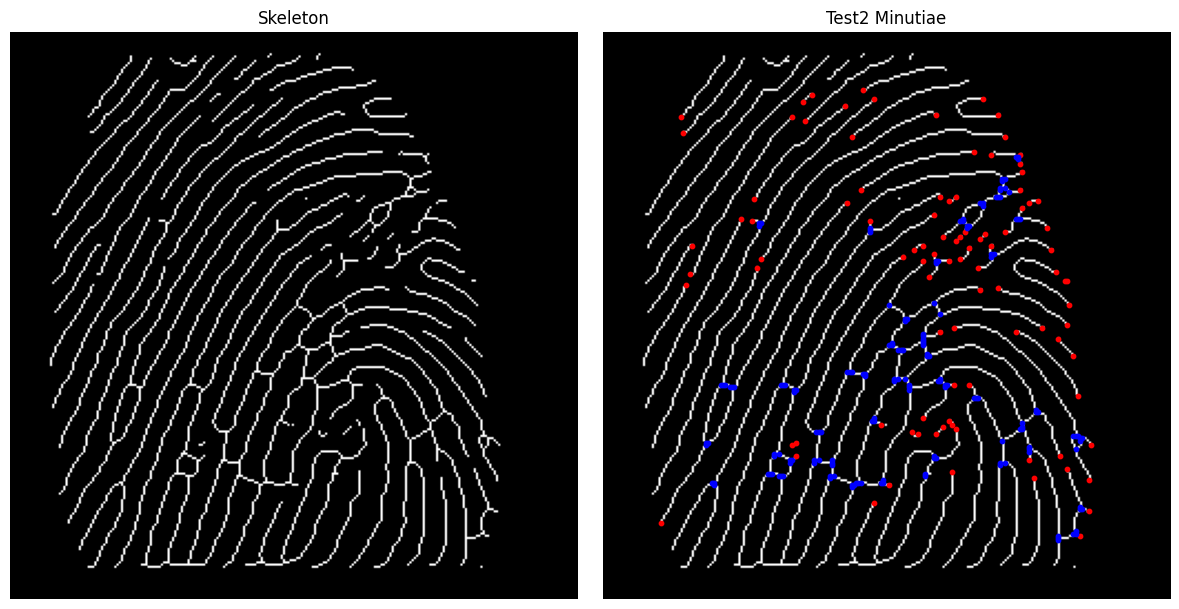

In [6]:
from skimage.morphology import convex_hull_image

sample_img = list(test2_images.values())[20]
skel, mask = preprocess_with_mask(sample_img)
minutiae = extract_minutiae_with_mask(skel, mask)
# minutiae['end'], minutiae['bif'] 사용

x_end_r, y_end_r = zip(*minutiae['end'])
x_bif_r, y_bif_r = zip(*minutiae['bif'])

def plot_minutiae(img, minutiae, title='Minutiae'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(skel, cmap='gray')
    axes[0].set_title('Skeleton')
    axes[1].imshow(skel, cmap='gray')
    axes[1].scatter(*zip(*minutiae['end']), color='red', label='Endings', s=10)
    axes[1].scatter(*zip(*minutiae['bif']), color='blue', label='Bifurcations', s=10)
    axes[1].set_title(title)
    for ax in axes.ravel():
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_minutiae(sample_img, minutiae, title='Test2 Minutiae')


# EASY) Test2의 이미지를 활용하여 train 이미지와 매칭

In [ ]:
#── 1) train/test2 이미지를 전처리한 후, minutiae(분기점+종단점)만 추출해 딕셔너리로 저장
features_train = {
    name: extract_minutiae_with_mask(*preprocess_with_mask(img))
    for name, img in train_images.items()
}
features_test2 = {
    name: extract_minutiae_with_mask(*preprocess_with_mask(img))
    for name, img in test2_images.items()
}

In [ ]:
# 잘 추출됐는지 확인
print(len(t_points), len(r_points))

In [25]:
from scipy.spatial import cKDTree

def fast_minutiae_distance(query_points, train_points):
    """
    query_points, train_points: [(x,y), ...]
    returns: max_dist, min_dist, mean_dist, num_matches
    """
    if len(query_points) == 0 or len(train_points) == 0:
        return np.inf, np.inf, np.inf, 0

    q = np.array(query_points, dtype=np.float32)
    t = np.array(train_points, dtype=np.float32)

    tree = cKDTree(t)
    # 각 query에 대해 가장 가까운 train 점까지의 거리
    dists, _ = tree.query(q, k=1)
    return dists.max(), dists.min(), dists.mean(), len(dists)

In [26]:
# ── EASY(Test2) 매칭: “평균 거리” 기준으로 가장 작은 것 선택
pred_test2 = {}
score_test2 = {}

for tname, tminu in features_test2.items():
    t_points = tminu['end'] + tminu['bif']
    best_mean = np.inf
    best_train = None

    for rname, rminu in features_train.items():
        r_points = rminu['end'] + rminu['bif']
        _, _, mean_dist, _ = fast_minutiae_distance(t_points, r_points)

        if mean_dist < best_mean:
            best_mean = mean_dist
            best_train = rname

    pred_test2[tname]  = best_train
    score_test2[tname] = best_mean

# 결과 출력
for tname, trainname in pred_test2.items():
    print(f"{tname} → {trainname}    (mean distance: {score_test2[tname]:.2f}px)")


100_type1.BMP → 100.BMP    (mean distance: 1.56px)
100_type2.BMP → 100.BMP    (mean distance: 1.78px)
100_type3.BMP → 100.BMP    (mean distance: 0.81px)
101_type1.BMP → 101.BMP    (mean distance: 3.32px)
101_type2.BMP → 101.BMP    (mean distance: 2.46px)
101_type3.BMP → 101.BMP    (mean distance: 1.27px)
102_type1.BMP → 102.BMP    (mean distance: 1.33px)
102_type2.BMP → 102.BMP    (mean distance: 1.45px)
102_type3.BMP → 102.BMP    (mean distance: 0.45px)
104_type1.BMP → 104.BMP    (mean distance: 1.62px)
104_type2.BMP → 104.BMP    (mean distance: 2.26px)
104_type3.BMP → 104.BMP    (mean distance: 0.58px)
105_type1.BMP → 105.BMP    (mean distance: 1.15px)
105_type2.BMP → 105.BMP    (mean distance: 1.44px)
105_type3.BMP → 105.BMP    (mean distance: 0.51px)
106_type1.BMP → 106.BMP    (mean distance: 1.54px)
106_type2.BMP → 106.BMP    (mean distance: 2.28px)
106_type3.BMP → 106.BMP    (mean distance: 0.67px)
107_type1.BMP → 107.BMP    (mean distance: 1.96px)
107_type2.BMP → 107.BMP    (mea

In [ ]:
# 1) threshold 선정
threshold = 2

# 2) 실제 레이블 뽑기 (파일명이 '{ID}_something.bmp' 형태)
y_true = [tname.split('_')[0] + '.BMP' for tname in features_test2.keys()]
y_pred = [pred_test2[tname]                 for tname in features_test2.keys()]
y_score = [score_test2[tname]               for tname in features_test2.keys()]

# 3) accept/reject 결정
y_accept = [dist <= threshold for dist in y_score]

# 4) Genuine vs Imposter 구분
is_genuine  = [yt == yp for yt, yp in zip(y_true, y_pred)]

TP = sum(1 for g, a in zip(is_genuine, y_accept) if g and a)
FN = sum(1 for g, a in zip(is_genuine, y_accept) if g and not a)
FP = sum(1 for g, a in zip(is_genuine, y_accept) if not g and a)
TN = sum(1 for g, a in zip(is_genuine, y_accept) if not g and not a)

precision = TP / (TP + FP) if TP+FP else 0
recall    = TP / (TP + FN) if TP+FN else 0
FAR       = FP / (FP + TN) if FP+TN else 0
FRR       = FN / (TP + FN) if TP+FN else 0
ACC       = (TP + TN) / (TP + TN + FP + FN)

print(f"Threshold = {threshold}px")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"FAR:       {FAR:.3f}")
print(f"FRR:       {FRR:.3f}")
print(f"Accuracy:  {ACC:.3f}")


Threshold = 2px
Precision: 1.000
Recall:    0.708
FAR:       0.000
FRR:       0.292
Accuracy:  0.730


In [7]:
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt

def match_minutiae_points(q_points, r_points, threshold=15):
    """
    q_points: [(x,y), …]  – query(test) 지문의 minutiae 좌표
    r_points: [(x,y), …]  – reference(train) 지문의 minutiae 좌표
    threshold: 픽셀 단위 거리 임계치 (이내만 매칭)
    returns: [((xq,yq),(xr,yr)), …] 형태의 매칭 리스트
    """
    if not q_points or not r_points:
        return []
    q = np.array(q_points, dtype=np.float32)
    r = np.array(r_points, dtype=np.float32)
    tree = KDTree(r)
    dists, idxs = tree.query(q, k=1)
    matches = []
    for (xq,yq), idx, dist in zip(q_points, idxs, dists):
        if dist <= threshold:
            xr, yr = r_points[idx]
            matches.append(((xq,yq),(xr,yr)))
    return matches

def plot_matched_minutiae(img_q, img_r, matches, figsize=(12,6)):
    """
    img_q: query image (예: skeleton)
    img_r: reference image
    matches: match_minutiae_points 의 반환값
    """
    h1, w1 = img_q.shape
    h2, w2 = img_r.shape
    # 두 이미지를 가로로 이어붙인 새 배열
    canvas = np.zeros((max(h1,h2), w1+w2), dtype=img_q.dtype)
    canvas[:h1, :w1]       = img_q
    canvas[:h2, w1:w1+w2] = img_r

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.imshow(canvas, cmap='gray')
    ax.axis('off')

    for (xq,yq),(xr,yr) in matches:
        # 선 연결 (노란색), 좌표계 주의: train 쪽 x좌표 + w1
        ax.plot([xq, xr + w1], [yq, yr], '-', linewidth=0.5, color='yellow')
        # 점 표시
        ax.scatter([xq], [yq], s=15, facecolors='none', edgecolors='red')
        ax.scatter([xr + w1], [yr], s=15, facecolors='none', edgecolors='blue')

    plt.tight_layout()
    plt.show()


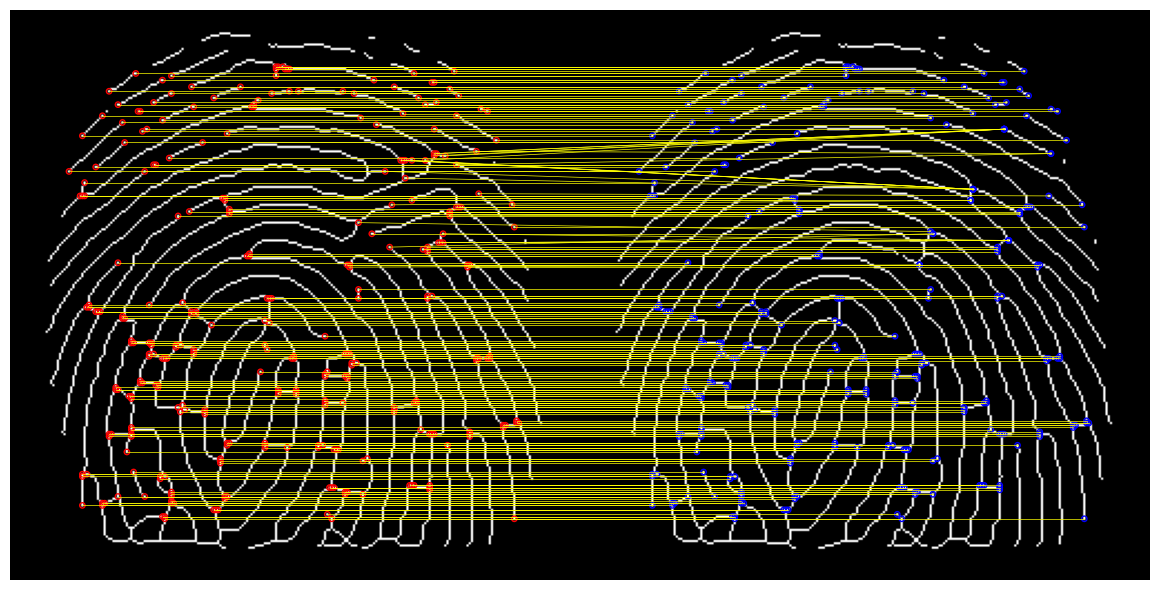

In [38]:
# 1) 원하는 test/train 파일명 선택
tname = '1_type3.BMP'
rname = pred_test2[tname]   # 이전에 구한 best match

# 2) 전처리 & minutiae 꺼내기
skel_t, mask_t = preprocess_with_mask(test2_images[tname])
skel_r, mask_r = preprocess_with_mask(train_images[rname])
minu_t = extract_minutiae_with_mask(skel_t, mask_t)
minu_r = extract_minutiae_with_mask(skel_r, mask_r)

# 3) 매칭 쌍 생성
points_t = minu_t['end'] + minu_t['bif']
points_r = minu_r['end'] + minu_r['bif']
matches = match_minutiae_points(points_t, points_r, threshold=15)

# 4) 시각화
plot_matched_minutiae(skel_t, skel_r, matches)


# HARD) Test1 이미지를 이용한 매칭

In [7]:
%pip show torch

Name: torch
Version: 1.13.1+cu116
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\programdata\anaconda3\envs\testenv\lib\site-packages
Requires: typing-extensions
Required-by: torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import time
import random
import numpy as np
from glob import glob
import cv2
from scipy.ndimage import convolve
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Build minutiae features
features_train = {
    n: extract_minutiae_with_mask(*preprocess_with_mask(img))
    for n,img in train_images.items()
}
features_test1 = {
    n: extract_minutiae_with_mask(*preprocess_with_mask(img))
    for n,img in test1_images.items()
}

# Prepare shapes
image_shapes = {n: img.shape for n,img in train_images.items()}

# minutiae_to_map
def minutiae_to_map(minu, shape):
    m = np.zeros(shape, dtype=np.uint8)
    for x,y in minu['end']:
        m[y,x] = 255
    for x,y in minu['bif']:
        m[y,x] = 128
    return m


In [10]:
class SiameseFingerprintDataset(Dataset):
    def __init__(self, feats, shapes, rotation_range=(-30, 30)):
        """
        feats:    {filename: {'end':[], 'bif':[]}}
        shapes:   {filename: (H, W)}
        rotation_range: (min_deg, max_deg)
        """
        self.features  = feats
        self.shapes    = shapes
        self.names     = list(feats.keys())
        self.id_map    = {n: n.split('_')[0] for n in self.names}
        self.rot_range = rotation_range

    def __len__(self):
        return len(self.names) * 2

    def __getitem__(self, idx):
        # 1) Anchor & positive/negative 선택
        n1  = random.choice(self.names)
        id1 = self.id_map[n1]
        if random.random() < 0.5:
            # Positive pair (같은 ID)
            candidates = [n for n in self.names if self.id_map[n] == id1 and n != n1]
            n2 = random.choice(candidates) if candidates else n1
            label = 1.0
        else:
            # Negative pair (다른 ID)
            candidates = [n for n in self.names if self.id_map[n] != id1]
            n2 = random.choice(candidates)
            label = -1.0

        # 2) 미뉴티아 맵 생성
        shape = self.shapes[n1]
        m1 = minutiae_to_map(self.features[n1], shape)
        m2 = minutiae_to_map(self.features[n2], shape)

        # 3) 랜덤 회전 증강
        angle = random.uniform(self.rot_range[0], self.rot_range[1])
        h, w  = shape
        M     = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        m1    = cv2.warpAffine(m1, M, (w, h), flags=cv2.INTER_NEAREST,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        m2    = cv2.warpAffine(m2, M, (w, h), flags=cv2.INTER_NEAREST,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)

        # 4) Tensor 변환
        t1 = torch.from_numpy(m1).unsqueeze(0).float() / 255.0
        t2 = torch.from_numpy(m2).unsqueeze(0).float() / 255.0

        return t1, t2, torch.tensor(label)




In [11]:
class SiameseNet(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,5,padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128,emb_dim)
    def forward_once(self,x):
        x = self.conv(x).view(x.size(0),-1)
        x = self.fc(x)
        return F.normalize(x,dim=1)
    def forward(self,a,b):
        return self.forward_once(a), self.forward_once(b)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
# Full Training
train_ds = SiameseFingerprintDataset(features_train, image_shapes)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
model = SiameseNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CosineEmbeddingLoss(margin=0.5)
for ep in range(1,21):
    model.train()
    tot=0
    for a,b,l in train_loader:
        a,b,l = a.to(device),b.to(device),l.to(device)
        opt.zero_grad()
        e1,e2 = model(a,b)
        lss = loss_fn(e1,e2,l)
        lss.backward(); opt.step()
        tot+=lss.item()
    print(f"Epoch {ep} Loss {tot/len(train_loader):.4f}")

# Inference on test1 & Metric
model.eval()
embs = {}
with torch.no_grad():
    for n in features_train:
        m = minutiae_to_map(features_train[n], image_shapes[n])
        t = torch.from_numpy(m).unsqueeze(0).unsqueeze(0).float()/255.
        embs[n] = model.forward_once(t.to(device)).cpu().numpy()
print("--- HARD Matching ---")
pred = {}
for n in features_test1:
    m = minutiae_to_map(features_test1[n], image_shapes[n])
    t = torch.from_numpy(m).unsqueeze(0).unsqueeze(0).float()/255.
    e = model.forward_once(t.to(device)).cpu().numpy()
    best=(float('inf'),None)
    for r,er in embs.items():
        d=np.linalg.norm(e-er)
        if d<best[0]: best=(d,r)
    pred[n]=best[1]
    print(f"{n} -> {best[1]} dist {best[0]:.3f}")
y_true = [n.split('_')[0] for n in features_test1]
y_pred = [pred[n].split('_')[0] for n in features_test1]
acc = sum(yt==yp for yt,yp in zip(y_true,y_pred))/len(y_true)
print(f"Test1 Accuracy: {acc:.3f}")
